In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("NBA_BBDD_CLEAN.csv")
print(df.columns)

Index(['GAME_ID', 'NEW_GAME_EVENT_ID', 'PLAYER_ID', 'PLAYER_NAME', 'TEAM_ID',
       'TEAM_NAME', 'PERIOD', 'MINUTES_REMAINING', 'SECONDS_REMAINING',
       'EVENT_TYPE', 'ACTION_TYPE', 'SHOT_TYPE', 'SHOT_ZONE_BASIC',
       'SHOT_ZONE_AREA', 'LOC_X', 'LOC_Y', 'SHOT_ATTEMPTED_FLAG',
       'SHOT_MADE_FLAG', 'GAME_DATE', 'SEASON TYPE', 'HOME_TEAM_NAME',
       'AWAY_TEAM_NAME', 'LOCATION', 'POS', 'SHOT_DISTANCE_METERS',
       'SHOT_ZONE_RANGE_METERS'],
      dtype='object')


In [3]:


import pandas as pd
import numpy as np

# =================================================================
# PARÁMETROS AJUSTABLES
# =================================================================
n_players = 5                   
sort_by = "total_shots"    #Opciones: "FG%	made_shots	total_shots	2PT FG%	made_2pt	total_2pt	3PT FG%	made_3pt	total_3pt"        
min_attempts = 400                
min_percentage = 35               
season_type = "Totales"  # Opciones: "Regular Season", "Playoffs", "Totales"
# =================================================================

# =================================================================
# BLOQUE 1: PROCESAMIENTO DE DATOS (JUGADORES Y EQUIPOS)
# =================================================================
# Procesamiento de datos de jugadores
filtered_data = df[df["SHOT_TYPE"].isin(["2PT Field Goal", "3PT Field Goal"])]

# Aplicar filtro de temporada
if season_type != "Totales":
    filtered_data = filtered_data[filtered_data["SEASON TYPE"] == season_type]

# Agrupar datos de jugadores
grouped = filtered_data.groupby(["PLAYER_NAME", "SHOT_TYPE"]).agg(
    total_shots=("SHOT_ATTEMPTED_FLAG", "sum"),
    made_shots=("SHOT_MADE_FLAG", "sum")
).unstack(fill_value=0)

# Procesar columnas y cálculos
grouped.columns = ["total_2pt", "total_3pt", "made_2pt", "made_3pt"]
grouped["total_shots"] = grouped["total_2pt"] + grouped["total_3pt"]
grouped["made_shots"] = grouped["made_2pt"] + grouped["made_3pt"]

grouped["FG%"] = (grouped["made_shots"] / grouped["total_shots"] * 100).round(2)
grouped["2PT FG%"] = (grouped["made_2pt"] / grouped["total_2pt"] * 100).round(2).fillna(0)
grouped["3PT FG%"] = (grouped["made_3pt"] / grouped["total_3pt"] * 100).round(2).fillna(0)

# Procesamiento de datos de equipos
df_team = df.copy() if season_type == "Totales" else df[df["SEASON TYPE"] == season_type]

team_stats = df_team[df_team["SHOT_ATTEMPTED_FLAG"] == 1].groupby(["TEAM_NAME", "SHOT_TYPE"]).agg(
    Attempts=("SHOT_MADE_FLAG", "count"),
    Made=("SHOT_MADE_FLAG", "sum")
).reset_index()

team_stats["FG%"] = (team_stats["Made"] / team_stats["Attempts"] * 100).round(1)
pivot_team = team_stats.pivot(index="TEAM_NAME", columns="SHOT_TYPE", values="FG%")
# =================================================================

# =================================================================
# BLOQUE 2: FILTRADO Y MERGE CON DATOS DE EQUIPOS
# =================================================================
# Mapeo de columnas de filtro
filter_map = {
    "FG%": "total_shots",
    "2PT FG%": "total_2pt",
    "3PT FG%": "total_3pt",
    "total_shots": "total_shots",
    "made_shots": "total_shots",
    "made_2pt": "total_2pt",
    "total_2pt": "total_2pt",
    "made_3pt": "total_3pt",
    "total_3pt": "total_3pt"
}

filter_column = filter_map.get(sort_by, "total_shots")

# Aplicar filtros
filtered_stats = grouped[grouped[filter_column] >= min_attempts]

if sort_by in ["FG%", "2PT FG%", "3PT FG%"]:
    filtered_stats = filtered_stats[filtered_stats[sort_by] >= min_percentage]

# Seleccionar top jugadores
top_players = filtered_stats.sort_values(by=sort_by, ascending=False).head(n_players)

# Obtener información adicional de jugadores
player_info = df.groupby("PLAYER_NAME").agg(
    POS=("POS", lambda x: ", ".join(pd.unique(x))),
    TEAM_NAME=("TEAM_NAME", lambda x: ", ".join(pd.unique(x)))
)

# Fusionar datos
top_players = top_players.merge(player_info, left_index=True, right_index=True, how="left")
top_players = top_players.reset_index()
top_players["TEAM_NAME"] = top_players["TEAM_NAME"].str.split(", ").str[0]

# Fusionar estadísticas de equipo
top_players = top_players.merge(
    pivot_team[["2PT Field Goal", "3PT Field Goal"]],
    left_on="TEAM_NAME",
    right_index=True,
    how="left"
)

# Renombrar y ordenar columnas
top_players.rename(columns={
    "2PT Field Goal": "Team 2PT FG%",
    "3PT Field Goal": "Team 3PT FG%"
}, inplace=True)

column_order = [
    "PLAYER_NAME", "POS", "FG%", "made_shots", "total_shots",
    "2PT FG%", "made_2pt", "total_2pt",
    "3PT FG%", "made_3pt", "total_3pt",
    "TEAM_NAME", "Team 2PT FG%", "Team 3PT FG%"
]

top_players = top_players[column_order].reset_index(drop=True)
# =================================================================

top_players

PLAYER_NAME POS    FG%  made_shots  total_shots  2PT FG%  \
0              Luka Doncic   B  47.73        1029         2156    56.37   
1            Jalen Brunson   B  47.33         941         1988    51.09   
2          Anthony Edwards   B  46.44         874         1882    51.66   
3             Jayson Tatum   A  46.22         831         1798    53.57   
4  Shai Gilgeous-Alexander   B  53.01         907         1711    56.65   

   made_2pt  total_2pt  3PT FG%  made_3pt  total_3pt               TEAM_NAME  \
0       677       1201    36.86       352        955        Dallas Mavericks   
1       704       1378    38.85       237        610         New York Knicks   
2       638       1235    36.48       236        647  Minnesota Timberwolves   
3       563       1051    35.88       268        747          Boston Celtics   
4       796       1405    36.27       111        306   Oklahoma City Thunder   

   Team 2PT FG%  Team 3PT FG%  
0          57.2          36.8  
1          52.6          37.0  
2          54.5          38.2  
3          57.5          38.2  
4          56.3          38.5

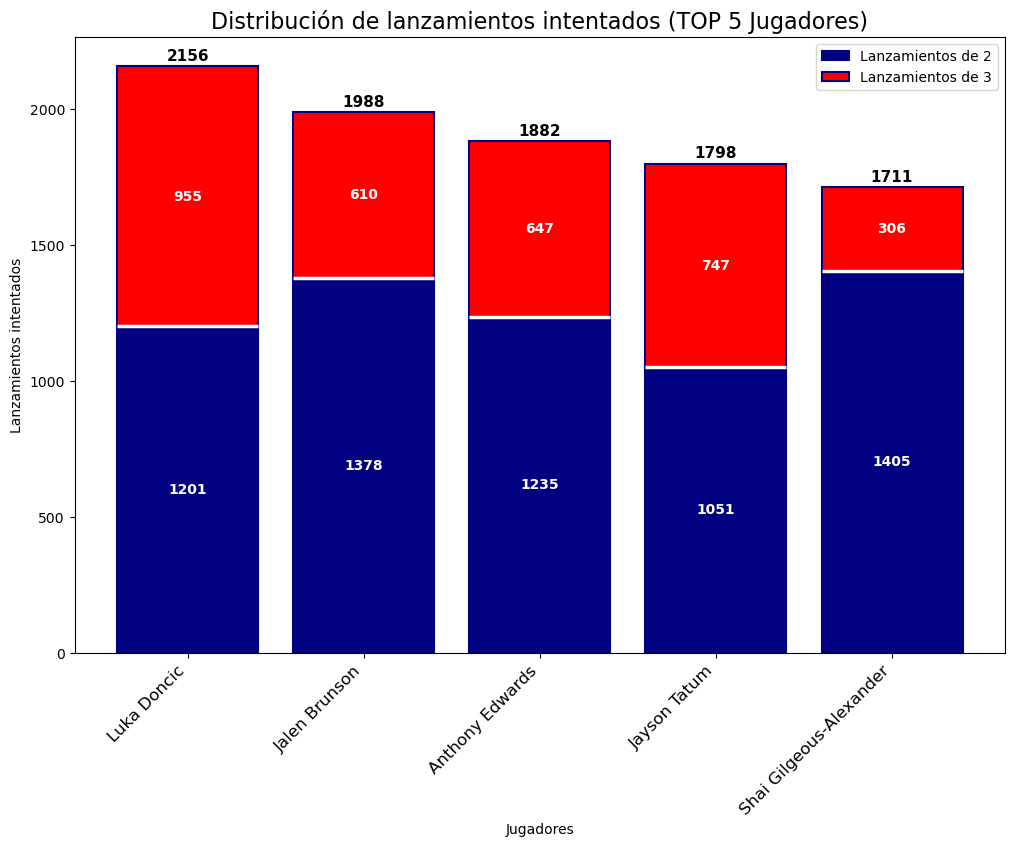

In [4]:
import matplotlib.pyplot as plt

# Crear la figura y el eje
fig, ax = plt.subplots(figsize=(12, 8))

# Datos para la gráfica
players = top_players["PLAYER_NAME"]
total_2pt = top_players["total_2pt"]
total_3pt = top_players["total_3pt"]
total_shots = top_players["total_shots"]

# Crear barras apiladas con bordes
bars_2pt = ax.bar(players, total_2pt, label="Lanzamientos de 2", 
                   color="navy", edgecolor="navy", linewidth=1.5)

bars_3pt = ax.bar(players, total_3pt, bottom=total_2pt, label="Lanzamientos de 3", 
                   color="red", edgecolor="navy", linewidth=1.5)

# Agregar una línea blanca dentro de las barras (borde superior de la barra de 2PT)
for bar, height in zip(bars_2pt, total_2pt):
    ax.hlines(y=height, xmin=bar.get_x(), xmax=bar.get_x() + bar.get_width(), 
              color="white", linewidth=2.5)

# Agregar los valores dentro de las barras
for bar, val in zip(bars_2pt, total_2pt):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height()/2, str(val),
            ha='center', va='center', fontsize=10, color='white', fontweight='bold')

for bar, val, bottom in zip(bars_3pt, total_3pt, total_2pt):
    ax.text(bar.get_x() + bar.get_width()/2, bottom + bar.get_height()/2, str(val),
            ha='center', va='center', fontsize=10, color='white', fontweight='bold')

# Agregar los valores totales arriba de cada barra
for bar, val in zip(bars_3pt, total_shots):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_y() + bar.get_height() + 10, str(val),
            ha='center', va='bottom', fontsize=11, color='black', fontweight='bold')

# Etiquetas y título
ax.set_xlabel("Jugadores")
ax.set_ylabel("Lanzamientos intentados")
ax.set_title("Distribución de lanzamientos intentados (TOP 5 Jugadores)", fontsize = 16)

# Eliminar la cuadrícula
ax.grid(False)

# Rotar nombres de los jugadores si son muchos
plt.xticks(rotation=45, ha="right", fontsize= 12)

# Agregar la leyenda
ax.legend()

# Mostrar gráfico
plt.show()


## MAPAS DE CALOR

### CANCHA NBA

In [5]:
from matplotlib.patches import Circle, Rectangle, Arc

def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

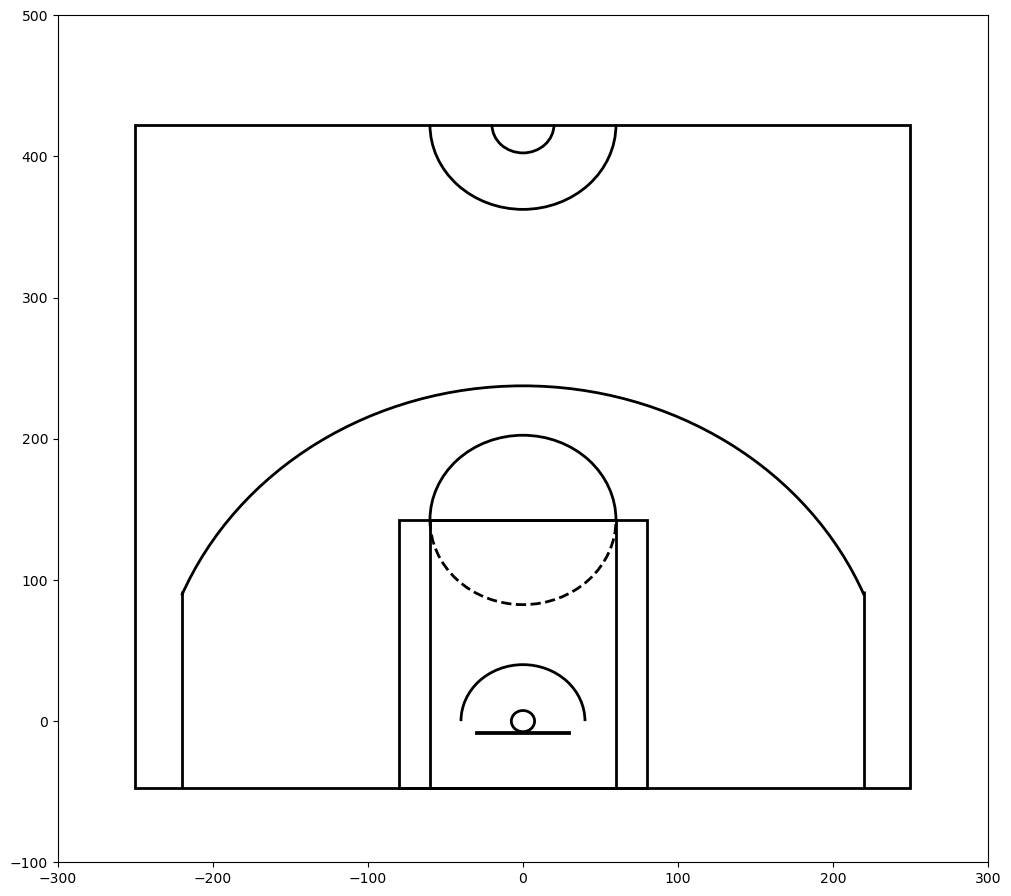

In [6]:
plt.figure(figsize=(12,11))
draw_court(outer_lines=True)
plt.xlim(-300,300)
plt.ylim(-100,500)
plt.show()

In [7]:
# Calcular intentos y aciertos por jugador
intentos = df.groupby("PLAYER_NAME")["SHOT_ATTEMPTED_FLAG"].sum()
aciertos = df.groupby("PLAYER_NAME")["SHOT_MADE_FLAG"].sum()
fallos = intentos - aciertos  # Fallos = intentos totales - aciertos

# Calcular partidos jugados por jugador
partidos = df.groupby("PLAYER_NAME")["GAME_ID"].nunique()
aciertos_por_partido = aciertos / partidos
fallos_por_partido = fallos / partidos

# Crear un DataFrame con las estadísticas
estadisticas_tiros = pd.DataFrame({
    "Aciertos por Partido": aciertos_por_partido,
    "Fallos por Partido": fallos_por_partido
})

# Seleccionar el jugador con el mejor promedio de aciertos por partido
top_player_by_avg = aciertos_por_partido.idxmax()  # Jugador con el mayor promedio de aciertos por partido
top_player_avg = aciertos_por_partido.max()  # Promedio de aciertos por partido

# Filtrar solo los tiros encestados
df_made_shots = df[df["SHOT_MADE_FLAG"] == 1]

# Agrupar por jugador y tipo de tiro, contando los encestados
top_scorers = df_made_shots.groupby(["PLAYER_NAME", "SHOT_TYPE"]).size().reset_index(name="TOTAL_MADE")

# Encontrar el jugador con más triples encestados
top_three_point_scorer = top_scorers[top_scorers["SHOT_TYPE"] == "3PT Field Goal"].sort_values(by="TOTAL_MADE", ascending=False).iloc[0]

# Encontrar el jugador con más tiros de dos encestados
top_two_point_scorer = top_scorers[top_scorers["SHOT_TYPE"] == "2PT Field Goal"].sort_values(by="TOTAL_MADE", ascending=False).iloc[0]

# Encontrar el jugador con más lanzamientos intentados en total
top_attempts_scorer = df.groupby("PLAYER_NAME").size().reset_index(name="TOTAL_ATTEMPTS").sort_values(by="TOTAL_ATTEMPTS", ascending=False).iloc[0]

# Filtrar a los jugadores que han intentado al menos 400 tiros
player_stats = df.groupby("PLAYER_NAME").agg(
    TOTAL_ATTEMPTS=('SHOT_MADE_FLAG', 'size'),
    TOTAL_MADE=('SHOT_MADE_FLAG', 'sum')
).reset_index()

player_stats = player_stats[player_stats['TOTAL_ATTEMPTS'] >= 400]  # Filtrar por mínimo de 400 intentos

# Calcular el porcentaje de acierto de cada jugador
player_stats['ACCURACY'] = player_stats['TOTAL_MADE'] / player_stats['TOTAL_ATTEMPTS'] * 100

# Encontrar el jugador con el mejor porcentaje de acierto
top_accuracy_scorer = player_stats.sort_values(by="ACCURACY", ascending=False).iloc[0]

# Mostrar los resultados
print(f"Jugador con más triples encestados: {top_three_point_scorer['PLAYER_NAME']} con [{top_three_point_scorer['TOTAL_MADE']}] triples.")
print(f"Jugador con más tiros de dos encestados: {top_two_point_scorer['PLAYER_NAME']} con [{top_two_point_scorer['TOTAL_MADE']}] tiros de dos.")
print(f"Jugador con más lanzamientos intentados: {top_attempts_scorer['PLAYER_NAME']} con [{top_attempts_scorer['TOTAL_ATTEMPTS']}] intentos.")
print(f"Jugador con el mejor promedio de aciertos por partido: {top_player_by_avg} con [{top_player_avg:.2f}] aciertos por partido.")
print(f"Jugador con el mejor porcentaje de acierto (mínimo 400 intentos): {top_accuracy_scorer['PLAYER_NAME']} con un [{top_accuracy_scorer['ACCURACY']:.2f}%] de aciertos.")

Jugador con más triples encestados: Stephen Curry con [357] triples.
Jugador con más tiros de dos encestados: Nikola Jokic con [858] tiros de dos.
Jugador con más lanzamientos intentados: Luka Doncic con [2156] intentos.
Jugador con el mejor promedio de aciertos por partido: Giannis Antetokounmpo con [11.47] aciertos por partido.
Jugador con el mejor porcentaje de acierto (mínimo 400 intentos): Daniel Gafford con un [70.65%] de aciertos.


In [11]:
## DEFINIMOS JUGADOR

# Seleccionar un jugador más triplista
# jugador = "Stephen Curry"  # Cambia esto por el jugador que quieras analizar

#ESTADISTICAS DE LOS MEJORES 
#jugador = "Luka Doncic"  #Jugador con mas lanzamientos realizados
#jugador = "Giannis Antetokounmpo"  #Jugador con mejor ptomedio anotador por partido
jugador = "Stephen Curry" #Jugador con mas triples encestados
#jugador = "Nikola Jokic" #Jugador con mas canastas de dos encestadas
#jugador = "Daniel Gafford" #Jugador con mas canastas de dos encestadas

df_jugador = df[df["PLAYER_NAME"] == jugador]  # Filtrar los datos del jugador

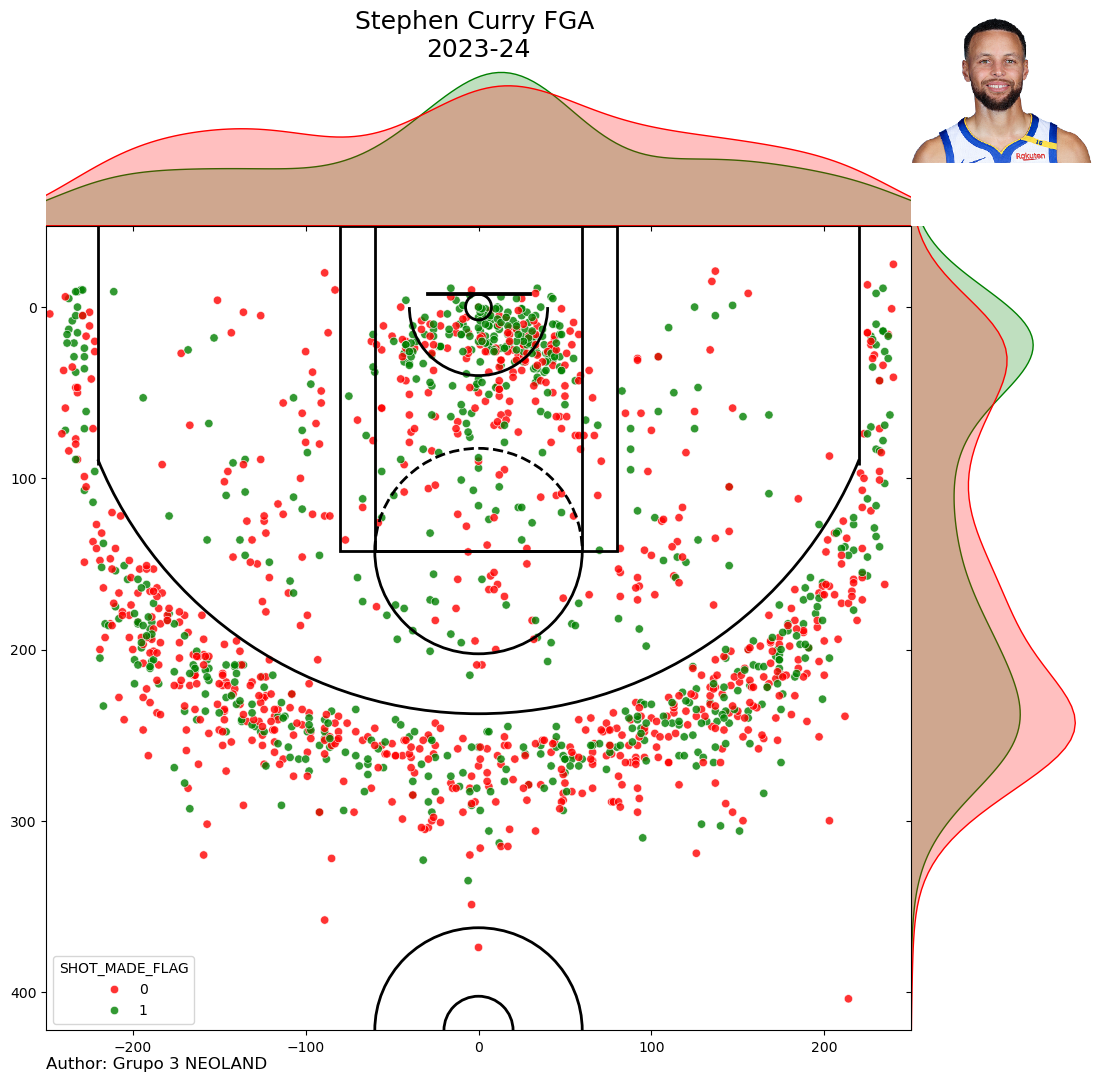

In [12]:
import matplotlib.image as mpimg  # Para cargar la imagen
from matplotlib.offsetbox import OffsetImage, AnnotationBbox  # Para posicionar la imagen
import seaborn as sns
import matplotlib.pyplot as plt

# Crear un jointplot de los tiros usando nombres de columnas como x e y
joint_shot_chart = sns.jointplot(x='LOC_X', y='LOC_Y', data=df_jugador,
                                 hue='SHOT_MADE_FLAG', palette={1: 'green', 0: 'red'},
                                 kind='scatter', space=0, alpha=0.8)

# Ajustar el tamaño de la figura
joint_shot_chart.fig.set_size_inches(12, 11)

# Obtener el objeto de los ejes del gráfico
ax = joint_shot_chart.ax_joint

# Dibujar la cancha sobre el gráfico
draw_court(ax=ax)

# Ajustar los límites del gráfico
ax.set_xlim(-250, 250)
ax.set_ylim(422.5, -47.5)

# Eliminar las etiquetas y los ticks de los ejes
ax.set_xlabel('')
ax.set_ylabel('')
ax.tick_params(labelbottom='off', labelleft='off')

# Añadir un título al gráfico
ax.set_title(f'{jugador} FGA \n2023-24', y=1.2, fontsize=18)

# Añadir texto de la fuente de datos y autor
ax.text(-250, 445, 'Author: Grupo 3 NEOLAND', fontsize=12)

# Cargar la imagen del jugador (asegúrate de tener la imagen en el directorio adecuado)
img_path = f'Fotos/{jugador}.png'  # Cambia este path por la ruta de la imagen del jugador
img = mpimg.imread(img_path)

# Crear un objeto OffsetImage a partir de la imagen cargada
# Aumentamos el zoom para hacer la imagen más grande
if jugador == "Nikola Jokic":
    imagebox = OffsetImage(img, zoom=0.35)  # Puedes cambiar el zoom para ajustar el tamaño de la imagen
    # Crear un objeto AnnotationBbox para colocar la imagen fuera de la cancha, en la esquina superior derecha
    ab = AnnotationBbox(imagebox, (0.74, 0.98), frameon=False, xycoords='figure fraction', boxcoords="figure fraction", 
                     box_alignment=(0, 1))  # La posición (1.05, 0.95) coloca la imagen fuera del gráfico
else:
    imagebox = OffsetImage(img, zoom=0.45)  # Puedes cambiar el zoom para ajustar el tamaño de la imagen
    # Crear un objeto AnnotationBbox para colocar la imagen fuera de la cancha, en la esquina superior derecha
    ab = AnnotationBbox(imagebox, (0.74, 0.98), frameon=False, xycoords='figure fraction', boxcoords="figure fraction", 
                    box_alignment=(0, 1))  # La posición (1.05, 0.95) coloca la imagen fuera del gráfico

# Añadir la imagen al gráfico
joint_shot_chart.fig.add_artist(ab)

# Mostrar el gráfico después de añadir la imagen
plt.show()

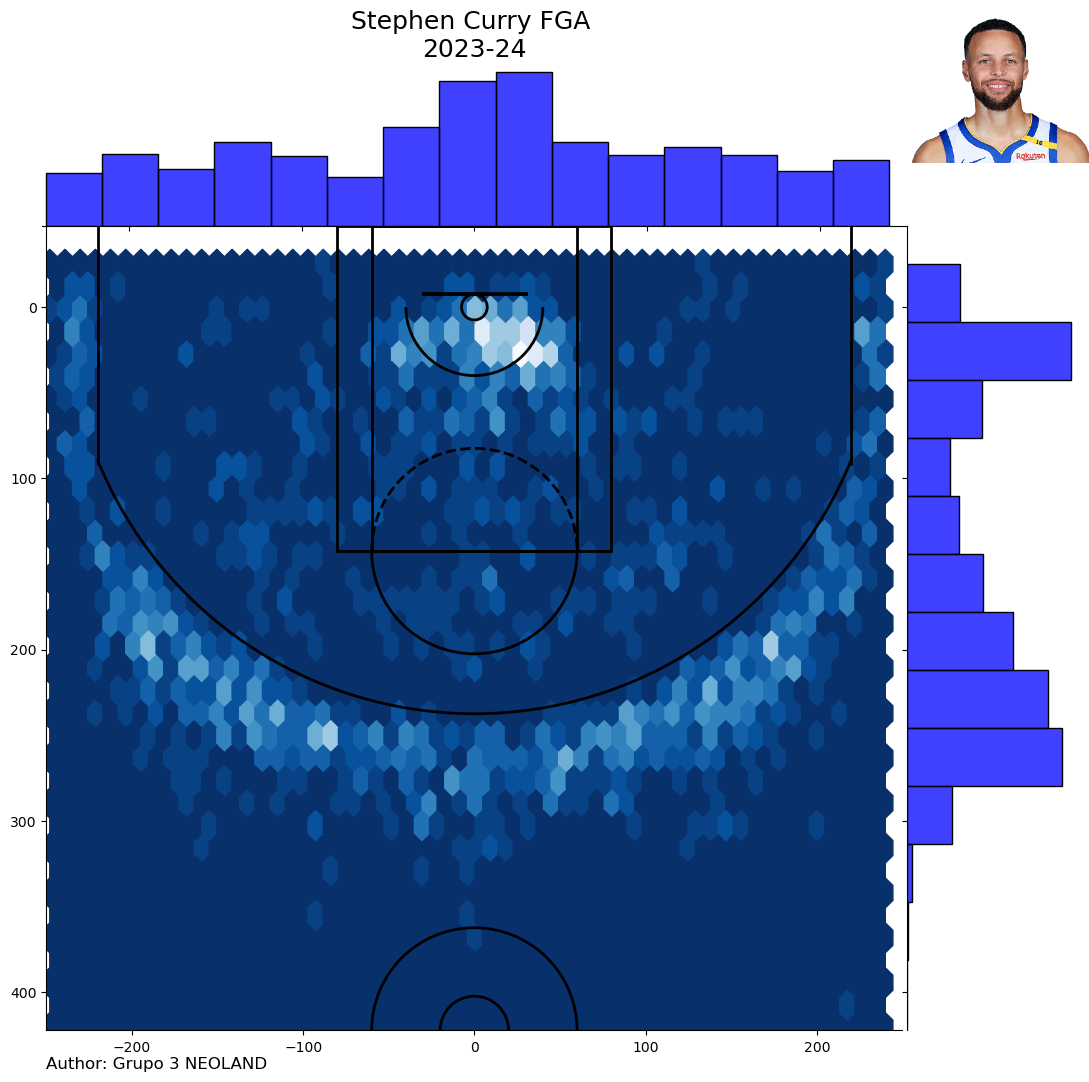

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Crear un jointplot de los tiros usa ndo nombres de columnas como x e y
# Ajusta el valor de gridsize para hacer los hexágonos más pequeños
joint_shot_chart = sns.jointplot(x='LOC_X', y='LOC_Y', data=df_jugador, cmap="Blues_r",
                                 kind='hex', space=0, color="blue",  # Usamos 'color' para un color único
                                 gridsize=55)

# Ajustar el tamaño de la figura
joint_shot_chart.fig.set_size_inches(12, 11)

# Obtener el objeto de los ejes del gráfico
ax = joint_shot_chart.ax_joint

# Dibujar la cancha sobre el gráfico
draw_court(ax=ax)

# Ajustar los límites del gráfico
ax.set_xlim(-250, 250)
ax.set_ylim(422.5, -47.5)

# Eliminar las etiquetas y los ticks de los ejes
ax.set_xlabel('')
ax.set_ylabel('')
ax.tick_params(labelbottom='off', labelleft='off')

# Añadir un título al gráfico
ax.set_title(f'{jugador} FGA \n2023-24', y=1.2, fontsize=18)

# Añadir texto de la fuente de datos y autor
ax.text(-250, 445, 'Author: Grupo 3 NEOLAND', fontsize=12)

# Ajustar la relación de aspecto para que los hexágonos no se vean alargados
ax.set_aspect('equal', 'box')  # Esto asegura que los ejes x e y tengan la misma escala

# Cargar la imagen del jugador (asegúrate de tener la imagen en el directorio adecuado)
img_path = f'Fotos/{jugador}.png'  # Cambia este path por la ruta de la imagen del jugador
img = mpimg.imread(img_path)

# Crear un objeto OffsetImage a partir de la imagen cargada
# Aumentamos el zoom para hacer la imagen más grande
imagebox = OffsetImage(img, zoom=0.45)  # Puedes cambiar el zoom para ajustar el tamaño de la imagen

if jugador == "Nikola Jokic":
    imagebox = OffsetImage(img, zoom=0.35)  # Puedes cambiar el zoom para ajustar el tamaño de la imagen
    # Crear un objeto AnnotationBbox para colocar la imagen fuera de la cancha, en la esquina superior derecha
    ab = AnnotationBbox(imagebox, (0.74, 0.98), frameon=False, xycoords='figure fraction', boxcoords="figure fraction", 
                     box_alignment=(0, 1))  # La posición (1.05, 0.95) coloca la imagen fuera del gráfico
else:
    imagebox = OffsetImage(img, zoom=0.45)  # Puedes cambiar el zoom para ajustar el tamaño de la imagen
    # Crear un objeto AnnotationBbox para colocar la imagen fuera de la cancha, en la esquina superior derecha
    ab = AnnotationBbox(imagebox, (0.74, 0.98), frameon=False, xycoords='figure fraction', boxcoords="figure fraction", 
                    box_alignment=(0, 1))  # La posición (1.05, 0.95) coloca la imagen fuera del gráfico

# Añadir la imagen al gráfico
joint_shot_chart.fig.add_artist(ab)

# Mostrar el gráfico después de añadir la imagen
plt.show()

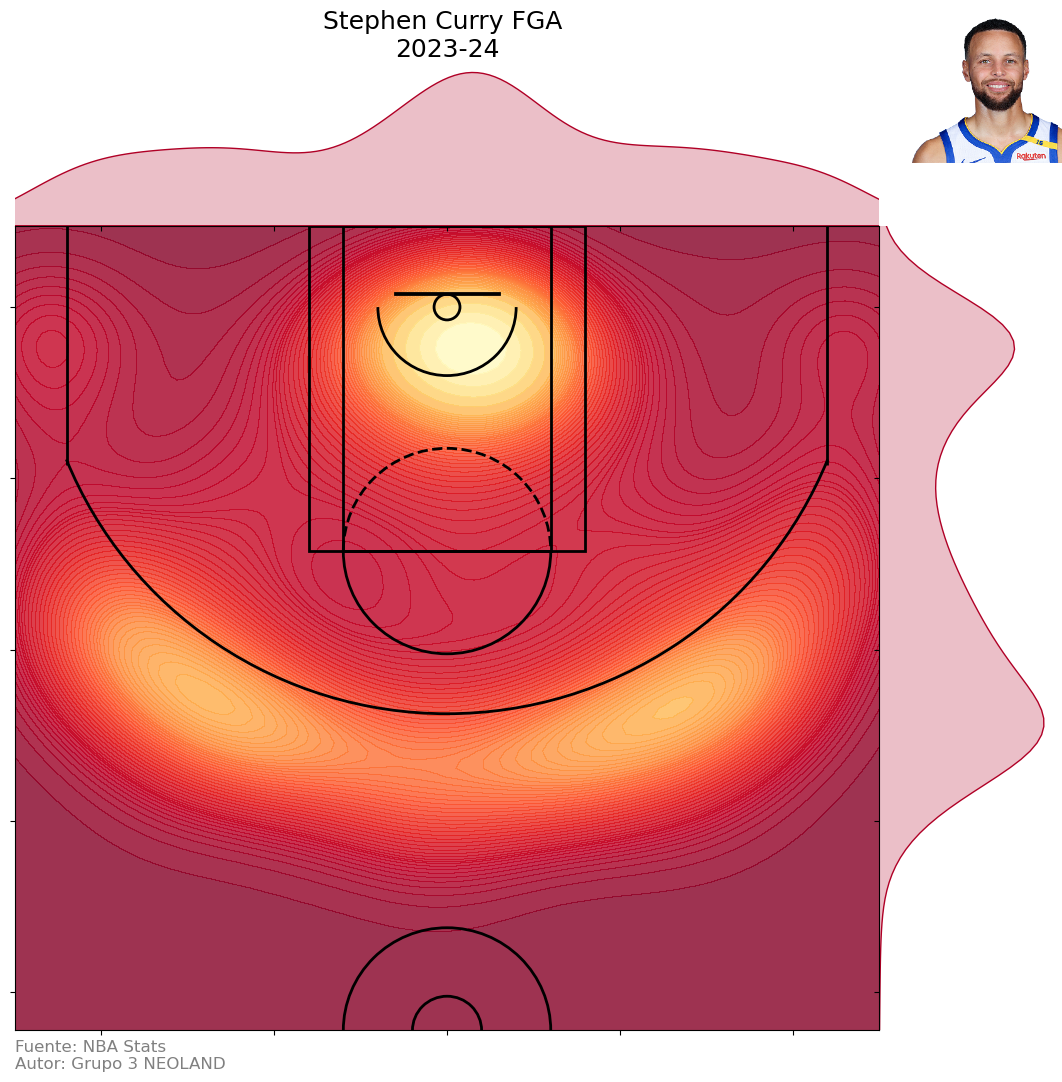

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Configuración del colormap para el mapa de calor
cmap = plt.cm.YlOrRd_r  

# Crear el jointplot con KDE (Kernel Density Estimation) para la distribución de tiros
joint_shot_chart = sns.jointplot(
    x='LOC_X', y='LOC_Y', data=df_jugador,
    kind='kde', space=0, cmap=cmap, color=cmap(0.1),
    n_levels=50,fill=True, thresh=0, alpha=0.8
)

# Ajustar el tamaño de la figura
joint_shot_chart.fig.set_size_inches(12, 11)

# Obtener el objeto de los ejes del gráfico principal
ax = joint_shot_chart.ax_joint

# Dibujar la cancha sobre el gráfico
draw_court(ax)

# Ajustar límites de la cancha (media cancha con aro arriba)
ax.set_xlim(-250, 250)
ax.set_ylim(422.5, -47.5)

# Eliminar etiquetas y ticks de los ejes para limpieza
ax.set_xlabel('')
ax.set_ylabel('')
ax.tick_params(labelbottom=False, labelleft=False)

# Añadir un título al gráfico
ax.set_title(f'{jugador} FGA \n2023-24', y=1.2, fontsize=18)

# Añadir fuente de datos y autor
ax.text(-250, 445, 'Fuente: NBA Stats\nAutor: Grupo 3 NEOLAND', fontsize=12, color='gray')

# Cargar la imagen del jugador (asegúrate de tener la imagen en el directorio adecuado)
img_path = f'Fotos/{jugador}.png'  # Cambia este path por la ruta de la imagen del jugador
img = mpimg.imread(img_path)

# Crear un objeto OffsetImage con zoom ajustado
imagebox = OffsetImage(img, zoom=0.45)

if jugador == "Nikola Jokic":
    imagebox = OffsetImage(img, zoom=0.35)  # Puedes cambiar el zoom para ajustar el tamaño de la imagen
    # Crear un objeto AnnotationBbox para colocar la imagen fuera de la cancha, en la esquina superior derecha
    ab = AnnotationBbox(imagebox, (0.72, 0.98), frameon=False, xycoords='figure fraction', boxcoords="figure fraction", 
                     box_alignment=(0, 1))  # La posición (1.05, 0.95) coloca la imagen fuera del gráfico
else:
    imagebox = OffsetImage(img, zoom=0.45)  # Puedes cambiar el zoom para ajustar el tamaño de la imagen
    # Crear un objeto AnnotationBbox para colocar la imagen fuera de la cancha, en la esquina superior derecha
    ab = AnnotationBbox(imagebox, (0.74, 0.98), frameon=False, xycoords='figure fraction', boxcoords="figure fraction", 
                    box_alignment=(0, 1))  # La posición (1.05, 0.95) coloca la imagen fuera del gráfico


# Añadir la imagen al gráfico
joint_shot_chart.fig.add_artist(ab)

# Mostrar el gráfico final
plt.show()

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filtrar solo los tiros de Stephen Curry (todas las temporadas)
durant_shots = df[df["PLAYER_NAME"] == "Stephen Curry"]

# Configurar el estilo
sns.set_style("white")

# Crear el jointplot con parámetros ajustados
joint_shot_chart = sns.jointplot(
    data=durant_shots,
    x="LOC_X",
    y="LOC_Y",
    kind="hex",
    cmap="Blues",
    joint_kws={
        "gridsize": 40,
        "extent": (-250, 250, -47.5, 422.5)
    },
    height=10,       # Altura total de la figura
    ratio=6,        # Proporción entre gráfico principal y marginales
    space=0         # Espacio entre subplots
)

# Obtener el eje principal y dibujar cancha
ax = joint_shot_chart.ax_joint
draw_court(ax, outer_lines=True, lw=1.2, color='#2d2d2d')

# Ajustar límites y aspecto
ax.set_xlim(-250, 250)
ax.set_ylim(422.5, -47.5)
ax.set_aspect('equal')

# Remover elementos decorativos
ax.set_xlabel('')
ax.set_ylabel('')
ax.tick_params(labelbottom=False, labelleft=False)

# Ajustar títulos
joint_shot_chart.fig.suptitle(
    "Stephen Curry FGA 2023-2024",
    fontsize=20,
    y=0.95  # Posición más ajustada
)
joint_shot_chart.fig.text(
    0.5, 0.01,
    "Temporadas 2009-2023 | Datos: NBA",
    ha='center',
    fontsize=12,
    color='#666666'
)

# Ajuste fino de márgenes (valores pueden necesitar tweaking)
joint_shot_chart.fig.subplots_adjust(
    left=0.03,
    right=0.97,
    top=0.88,
    bottom=0.05
)

# Opcional: Para alta resolución en Jupyter
# plt.figure(dpi=120)

plt.show()

## RADARES COMPARATIVOS

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv("NBA_BBDD_CLEAN.csv")
print(df.columns)

In [18]:
import pandas as pd
import numpy as np

# =================================================================
# PARÁMETROS AJUSTABLES
# =================================================================
n_players = 150                   
sort_by = "made_2pt"    #Opciones: "FG%	made_shots	total_shots	2PT FG%	made_2pt	total_2pt	3PT FG%	made_3pt	total_3pt"        
min_attempts = 400                
min_percentage = 35               
season_type = "Totales"  # Opciones: "Regular Season", "Playoffs", "Totales"
# =================================================================

# =================================================================
# BLOQUE 1: PROCESAMIENTO DE DATOS (JUGADORES Y EQUIPOS)
# =================================================================
# Procesamiento de datos de jugadores
filtered_data = df[df["SHOT_TYPE"].isin(["2PT Field Goal", "3PT Field Goal"])]

# Aplicar filtro de temporada
if season_type != "Totales":
    filtered_data = filtered_data[filtered_data["SEASON TYPE"] == season_type]

# Agrupar datos de jugadores
grouped = filtered_data.groupby(["PLAYER_NAME", "SHOT_TYPE"]).agg(
    total_shots=("SHOT_ATTEMPTED_FLAG", "sum"),
    made_shots=("SHOT_MADE_FLAG", "sum")
).unstack(fill_value=0)

# Procesar columnas y cálculos
grouped.columns = ["total_2pt", "total_3pt", "made_2pt", "made_3pt"]
grouped["total_shots"] = grouped["total_2pt"] + grouped["total_3pt"]
grouped["made_shots"] = grouped["made_2pt"] + grouped["made_3pt"]

grouped["FG%"] = (grouped["made_shots"] / grouped["total_shots"] * 100).round(2)
grouped["2PT FG%"] = (grouped["made_2pt"] / grouped["total_2pt"] * 100).round(2).fillna(0)
grouped["3PT FG%"] = (grouped["made_3pt"] / grouped["total_3pt"] * 100).round(2).fillna(0)

# Procesamiento de datos de equipos
df_team = df.copy() if season_type == "Totales" else df[df["SEASON TYPE"] == season_type]

team_stats = df_team[df_team["SHOT_ATTEMPTED_FLAG"] == 1].groupby(["TEAM_NAME", "SHOT_TYPE"]).agg(
    Attempts=("SHOT_MADE_FLAG", "count"),
    Made=("SHOT_MADE_FLAG", "sum")
).reset_index()

team_stats["FG%"] = (team_stats["Made"] / team_stats["Attempts"] * 100).round(1)
pivot_team = team_stats.pivot(index="TEAM_NAME", columns="SHOT_TYPE", values="FG%")
# =================================================================

# =================================================================
# BLOQUE 2: FILTRADO Y MERGE CON DATOS DE EQUIPOS
# =================================================================
# Mapeo de columnas de filtro
filter_map = {
    "FG%": "total_shots",
    "2PT FG%": "total_2pt",
    "3PT FG%": "total_3pt",
    "total_shots": "total_shots", 
    "made_2pt": "total_2pt",
    "total_2pt": "total_2pt",
    "made_3pt": "total_3pt",
    "total_3pt": "total_3pt"
}

filter_column = filter_map.get(sort_by, "total_shots")

# Aplicar filtros
filtered_stats = grouped[grouped[filter_column] >= min_attempts]

if sort_by in ["FG%", "2PT FG%", "3PT FG%"]:
    filtered_stats = filtered_stats[filtered_stats[sort_by] >= min_percentage]

# Seleccionar top jugadores
top_players = filtered_stats.sort_values(by=sort_by, ascending=False).head(n_players)

# Obtener información adicional de jugadores
player_info = df.groupby("PLAYER_NAME").agg(
    POS=("POS", lambda x: ", ".join(pd.unique(x))),
    TEAM_NAME=("TEAM_NAME", lambda x: ", ".join(pd.unique(x)))
)

# Fusionar datos
top_players = top_players.merge(player_info, left_index=True, right_index=True, how="left")
top_players = top_players.reset_index()
top_players["TEAM_NAME"] = top_players["TEAM_NAME"].str.split(", ").str[0]

# Fusionar estadísticas de equipo
top_players = top_players.merge(
    pivot_team[["2PT Field Goal", "3PT Field Goal"]],
    left_on="TEAM_NAME",
    right_index=True,
    how="left"
)

# Renombrar y ordenar columnas
top_players.rename(columns={
    "2PT Field Goal": "Team 2PT FG%",
    "3PT Field Goal": "Team 3PT FG%"
}, inplace=True)

column_order = [
    "PLAYER_NAME", "POS", "FG%", "made_shots", "total_shots",
    "2PT FG%", "made_2pt", "total_2pt",
    "3PT FG%", "made_3pt", "total_3pt",
    "TEAM_NAME", "Team 2PT FG%", "Team 3PT FG%"
]

top_players = top_players[column_order].reset_index(drop=True)
# =================================================================

top_players

PLAYER_NAME    POS    FG%  made_shots  total_shots  2PT FG%  \
0               Nikola Jokic      P  57.74         955         1654    62.63   
1             Daniel Gafford  AP, P  70.65         852         1206    70.65   
2      Giannis Antetokounmpo      A  61.14         837         1369    64.50   
3    Shai Gilgeous-Alexander      B  53.01         907         1711    56.65   
4              Anthony Davis      P  56.10         772         1376    58.78   
..                       ...    ...    ...         ...          ...      ...   
130           Xavier Tillman   P, A  43.90         252          574    51.22   
131              Tyler Herro      B  43.54         354          813    47.37   
132          Anfernee Simons      B  43.01         360          837    47.22   
133            Fred VanVleet      B  41.55         423         1018    45.37   
134         Tim Hardaway Jr.     ES  40.04         414         1034    47.50   

     made_2pt  total_2pt  3PT FG%  made_3pt  total_3pt  \
0         858       1370    34.15        97        284   
1         852       1206     0.00         0          0   
2         803       1245    27.42        34        124   
3         796       1405    36.27       111        306   
4         743       1264    25.89        29        112   
..        ...        ...      ...       ...        ...   
130       210        410    25.61        42        164   
131       207        437    39.10       147        376   
132       204        432    38.52       156        405   
133       196        432    38.74       227        586   
134       190        400    35.33       224        634   

                  TEAM_NAME  Team 2PT FG%  Team 3PT FG%  
0            Denver Nuggets          55.8          36.9  
1        Washington Wizards          55.6          34.8  
2           Milwaukee Bucks          57.2          37.1  
3     Oklahoma City Thunder          56.3          38.5  
4        Los Angeles Lakers          56.9          37.3  
..                      ...           ...           ...  
130       Memphis Grizzlies          50.1          34.4  
131              Miami Heat          52.7          36.7  
132  Portland Trail Blazers          49.4          34.5  
133         Houston Rockets          53.0          35.2  
134        Dallas Mavericks          57.2          36.8  

[135 rows x 14 columns]

In [ ]:
# Jugador con mas triples intentados Doncic vs Jugador con mas triples encestados Curry

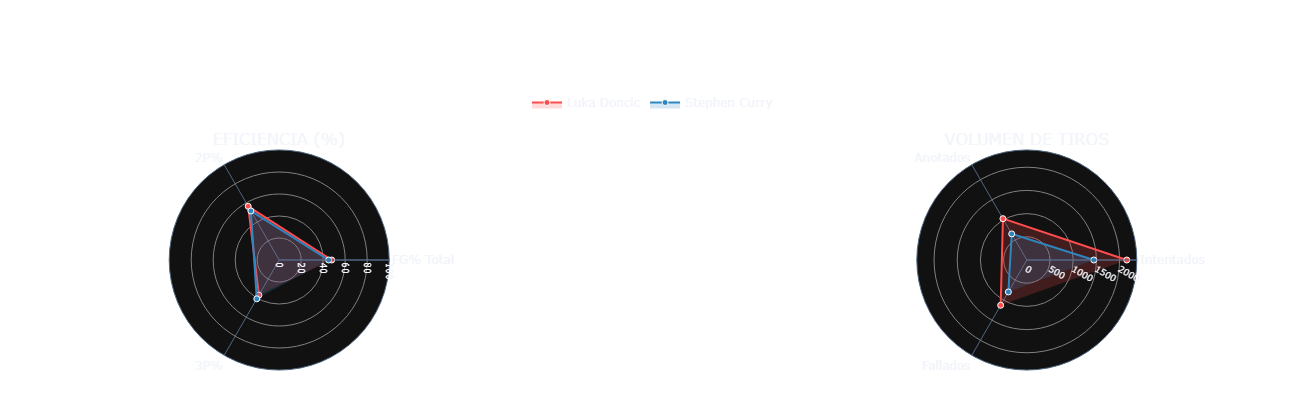

In [19]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import pandas as pd

# 1. Configuración inicial ---------------------------------------------------
jugadores = ['Luka Doncic', 'Stephen Curry']  # ¡Nombres exactos!

# Definición de paleta de colores para cada jugador (para líneas)
PALETA = {
    'Luka Doncic': '#FF4C4C',
    'Stephen Curry': '#2E86C1'
}
# Definición de colores con transparencia para el relleno (fillcolor)
PALETA_FILL = {
    'Luka Doncic': 'rgba(255, 76, 76, 0.2)',
    'Stephen Curry': 'rgba(46, 134, 193, 0.2)'
}

# 2. Validación de datos -----------------------------------------------------
df_radar = top_players[top_players['PLAYER_NAME'].isin(jugadores)].copy()
if df_radar.empty:
    disponibles = top_players['PLAYER_NAME'].unique().tolist()
    raise ValueError(f"Jugadores no encontrados. Disponibles: {disponibles}")

# Calcular tiros fallados (sin modificar la data base, solo se agrega para graficar)
df_radar["fallados"] = df_radar["total_shots"] - df_radar["made_shots"]

# 3. Creación de la figura con dos subgráficos (polares) ---------------------
fig = make_subplots(
    rows=1, 
    cols=2,
    specs=[[{'type': 'polar'}, {'type': 'polar'}]],
    subplot_titles=("EFICIENCIA (%)", "VOLUMEN DE TIROS"),
    horizontal_spacing=0.2
)

# 4. Radar de Eficiencia -----------------------------------------------------
for jugador in jugadores:
    data = df_radar[df_radar['PLAYER_NAME'] == jugador]
    if not data.empty:
        # Se agrega una traza para cada jugador con mayor grosor de línea y mayor tamaño de marcador
        fig.add_trace(
            go.Scatterpolar(
                r=data[['FG%', '2PT FG%', '3PT FG%']].values.flatten(),
                theta=['FG% Total', '2P%', '3P%'],
                name=jugador,
                fill='toself',
                fillcolor=PALETA_FILL[jugador],    # Relleno con transparencia
                line=dict(color=PALETA[jugador], width=2),  # Línea más gruesa
                marker=dict(size=6, color=PALETA[jugador],
                            line=dict(width=1, color='white')),  # Marcadores más grandes con borde blanco
                showlegend=True
            ),
            row=1, col=1
        )

# 5. Radar de Volumen --------------------------------------------------------
for jugador in jugadores:
    data = df_radar[df_radar['PLAYER_NAME'] == jugador]
    if not data.empty:
        # Se agrega la traza con las tres dimensiones: Intentados, Anotados y Fallados
        fig.add_trace(
            go.Scatterpolar(
                r=data[['total_shots', 'made_shots', 'fallados']].values.flatten(),
                theta=['Intentados', 'Anotados', 'Fallados'],
                name=jugador,
                fill='toself',
                fillcolor=PALETA_FILL[jugador],
                line=dict(color=PALETA[jugador], width=2),
                marker=dict(size=6, color=PALETA[jugador],
                            line=dict(width=1, color='white')),
                showlegend=False
            ),
            row=1, col=2
        )

# 6. Ajustes finales de diseño ------------------------------------------------
fig.update_layout(
    template='plotly_dark',
    # Título centrado y reposicionado para evitar solapamientos
    title=dict(
         text="<b>Comparativa de Jugadores</b>",
         font=dict(size=20, family="Arial", color="white"),
         x=0.5,
         y=0.98,
         xanchor="center",
         yanchor="top"
    ),
    margin=dict(t=150, b=30, l=30, r=30),
    # Leyenda personalizada para mayor legibilidad
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.15,
        xanchor="center",
        x=0.5,
        font=dict(size=12)
    ),
    width=800,
    height=400,
    # Se pueden definir colores de fondo para el "paper" y el área de la gráfica si se desea
    paper_bgcolor="rgba(0,0,0,0)",
    plot_bgcolor="rgba(0,0,0,0)"
)

# Ajuste del eje radial del radar de eficiencia: 
# Se configuran rangos, tick labels verticales y se agregan lineas de cuadrícula personalizadas.
fig.update_polars(
    radialaxis=dict(
        range=[0, 100],
        tickfont=dict(size=9),
        tickangle=90,           # Etiquetas verticales
        gridcolor='gray',       # Color de la cuadrícula
        gridwidth=1             # Ancho de la cuadrícula
    ),
    row=1, col=1
)

# Ajuste del eje radial del radar de volumen:
max_volumen = df_radar[['total_shots', 'made_shots', 'fallados']].max().max() * 1.1
fig.update_polars(
    radialaxis=dict(
        range=[0, max_volumen],
        tickfont=dict(size=9),
        gridcolor='gray',
        gridwidth=1
    ),
    row=1, col=2
)

# Ajuste específico para que la etiqueta "Intentados" se muestre completa en el radar de volumen:
# Se modifica la configuración del angular axis del subplot polar2.
fig.update_layout(
    polar2=dict(
         angularaxis=dict(
             tickfont=dict(size=12)
         )
    )
)

fig.show()

In [ ]:
## Comparacion Shai vs Jokic (made 2 points)

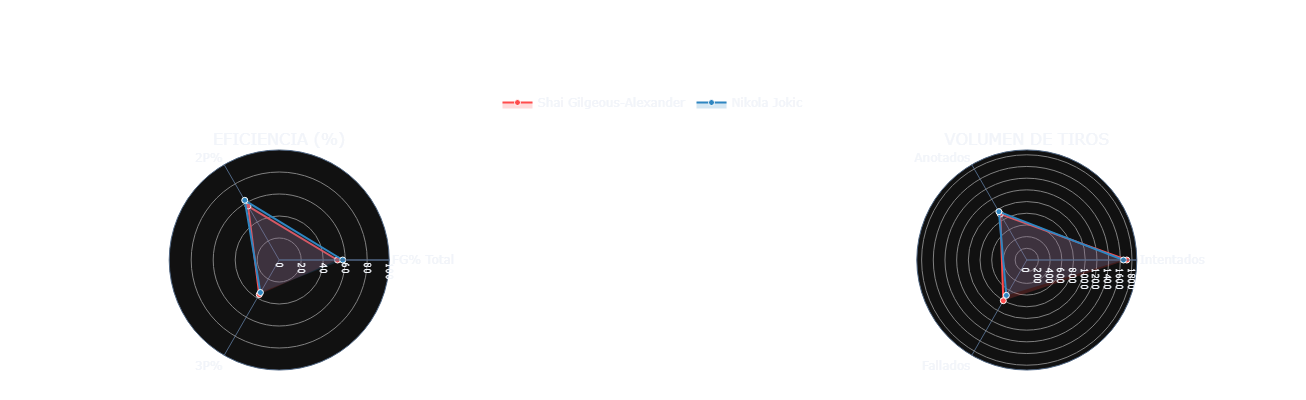

In [20]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import pandas as pd

# 1. Configuración inicial ---------------------------------------------------
jugadores = ['Shai Gilgeous-Alexander', 'Nikola Jokic']  # ¡Nombres exactos!

# Definición de paleta de colores para cada jugador (para líneas)
PALETA = {
    'Shai Gilgeous-Alexander': '#FF4C4C',
    'Nikola Jokic': '#2E86C1'
}
# Definición de colores con transparencia para el relleno (fillcolor)
PALETA_FILL = {
    'Shai Gilgeous-Alexander': 'rgba(255, 76, 76, 0.2)',
    'Nikola Jokic': 'rgba(46, 134, 193, 0.2)'
}

# 2. Validación de datos -----------------------------------------------------
df_radar = top_players[top_players['PLAYER_NAME'].isin(jugadores)].copy()
if df_radar.empty:
    disponibles = top_players['PLAYER_NAME'].unique().tolist()
    raise ValueError(f"Jugadores no encontrados. Disponibles: {disponibles}")

# Calcular tiros fallados (sin modificar la data base, solo se agrega para graficar)
df_radar["fallados"] = df_radar["total_shots"] - df_radar["made_shots"]

# 3. Creación de la figura con dos subgráficos (polares) ---------------------
fig = make_subplots(
    rows=1, 
    cols=2,
    specs=[[{'type': 'polar'}, {'type': 'polar'}]],
    subplot_titles=("EFICIENCIA (%)", "VOLUMEN DE TIROS"),
    horizontal_spacing=0.2
)

# 4. Radar de Eficiencia -----------------------------------------------------
for jugador in jugadores:
    data = df_radar[df_radar['PLAYER_NAME'] == jugador]
    if not data.empty:
        # Se agrega una traza para cada jugador con mayor grosor de línea y mayor tamaño de marcador
        fig.add_trace(
            go.Scatterpolar(
                r=data[['FG%', '2PT FG%', '3PT FG%']].values.flatten(),
                theta=['FG% Total', '2P%', '3P%'],
                name=jugador,
                fill='toself',
                fillcolor=PALETA_FILL[jugador],    # Relleno con transparencia
                line=dict(color=PALETA[jugador], width=2),  # Línea más gruesa
                marker=dict(size=6, color=PALETA[jugador],
                            line=dict(width=1, color='white')),  # Marcadores más grandes con borde blanco
                showlegend=True
            ),
            row=1, col=1
        )

# 5. Radar de Volumen --------------------------------------------------------
for jugador in jugadores:
    data = df_radar[df_radar['PLAYER_NAME'] == jugador]
    if not data.empty:
        # Se agrega la traza con las tres dimensiones: Intentados, Anotados y Fallados
        fig.add_trace(
            go.Scatterpolar(
                r=data[['total_shots', 'made_shots', 'fallados']].values.flatten(),
                theta=['Intentados', 'Anotados', 'Fallados'],
                name=jugador,
                fill='toself',
                fillcolor=PALETA_FILL[jugador],
                line=dict(color=PALETA[jugador], width=2),
                marker=dict(size=6, color=PALETA[jugador],
                            line=dict(width=1, color='white')),
                showlegend=False
            ),
            row=1, col=2
        )

# 6. Ajustes finales de diseño ------------------------------------------------
fig.update_layout(
    template='plotly_dark',
    # Título centrado y reposicionado para evitar solapamientos
    title=dict(
         text="<b>Comparativa de Jugadores</b>",
         font=dict(size=20, family="Arial", color="white"),
         x=0.5,
         y=0.98,
         xanchor="center",
         yanchor="top"
    ),
    margin=dict(t=150, b=30, l=30, r=30),
    # Leyenda personalizada para mayor legibilidad
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.15,
        xanchor="center",
        x=0.5,
        font=dict(size=12)
    ),
    width=800,
    height=400,
    # Se pueden definir colores de fondo para el "paper" y el área de la gráfica si se desea
    paper_bgcolor="rgba(0,0,0,0)",
    plot_bgcolor="rgba(0,0,0,0)"
)

# Ajuste del eje radial del radar de eficiencia: 
# Se configuran rangos, tick labels verticales y se agregan lineas de cuadrícula personalizadas.
fig.update_polars(
    radialaxis=dict(
        range=[0, 100],
        tickfont=dict(size=9),
        tickangle=90,           # Etiquetas verticales
        gridcolor='gray',       # Color de la cuadrícula
        gridwidth=1             # Ancho de la cuadrícula
    ),
    row=1, col=1
)

# Ajuste del eje radial del radar de volumen:
max_volumen = df_radar[['total_shots', 'made_shots', 'fallados']].max().max() * 1.1
fig.update_polars(
    radialaxis=dict(
        range=[0, max_volumen],
        tickfont=dict(size=9),
        gridcolor='gray',
        gridwidth=1
    ),
    row=1, col=2
)

# Ajuste específico para que la etiqueta "Intentados" se muestre completa en el radar de volumen:
# Se modifica la configuración del angular axis del subplot polar2.
fig.update_layout(
    polar2=dict(
         angularaxis=dict(
             tickfont=dict(size=12)
         )
    )
)

fig.show()

In [ ]:
#Jugador con mayor %3pt de la liga Grayson Allen vs Jugador con mayor %3pt de nuestro top 5 lanzadores Jalen brunson

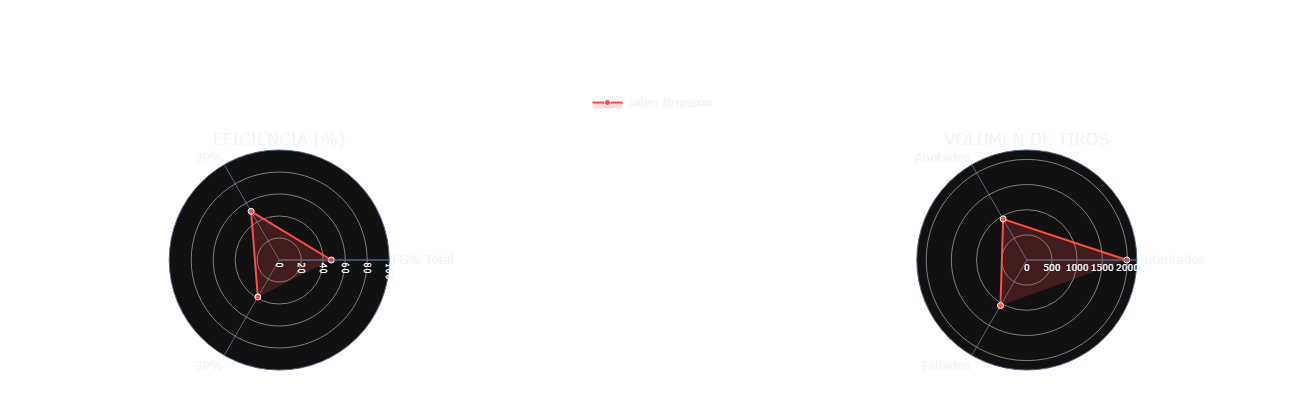

In [21]:
## Comparativa Jugadores Clave (Radar Chart) por total and made shots y porcentajes (AMBOS JUGADORES TIENEN QUE ESTAR EN LA TABLA top_players)

### MIRAR EN EFECTIVIDAD Y METER LOS TIROS FALLADOS, Y COMPARAR MEJORES VS PEORES

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import pandas as pd

# 1. Configuración inicial ---------------------------------------------------
jugadores = ['Jalen Brunson', 'Grayson Allen']  # ¡Nombres exactos!

# Definición de paleta de colores para cada jugador (para líneas)
PALETA = {
    'Jalen Brunson': '#FF4C4C',
    'Grayson Allen': '#2E86C1'
}
# Definición de colores con transparencia para el relleno (fillcolor)
PALETA_FILL = {
    'Jalen Brunson': 'rgba(255, 76, 76, 0.2)',
    'Grayson Allen': 'rgba(46, 134, 193, 0.2)'
}

# 2. Validación de datos -----------------------------------------------------
df_radar = top_players[top_players['PLAYER_NAME'].isin(jugadores)].copy()
if df_radar.empty:
    disponibles = top_players['PLAYER_NAME'].unique().tolist()
    raise ValueError(f"Jugadores no encontrados. Disponibles: {disponibles}")

# Calcular tiros fallados (sin modificar la data base, solo se agrega para graficar)
df_radar["fallados"] = df_radar["total_shots"] - df_radar["made_shots"]

# 3. Creación de la figura con dos subgráficos (polares) ---------------------
fig = make_subplots(
    rows=1, 
    cols=2,
    specs=[[{'type': 'polar'}, {'type': 'polar'}]],
    subplot_titles=("EFICIENCIA (%)", "VOLUMEN DE TIROS"),
    horizontal_spacing=0.2
)

# 4. Radar de Eficiencia -----------------------------------------------------
for jugador in jugadores:
    data = df_radar[df_radar['PLAYER_NAME'] == jugador]
    if not data.empty:
        # Se agrega una traza para cada jugador con mayor grosor de línea y mayor tamaño de marcador
        fig.add_trace(
            go.Scatterpolar(
                r=data[['FG%', '2PT FG%', '3PT FG%']].values.flatten(),
                theta=['FG% Total', '2P%', '3P%'],
                name=jugador,
                fill='toself',
                fillcolor=PALETA_FILL[jugador],    # Relleno con transparencia
                line=dict(color=PALETA[jugador], width=2),  # Línea más gruesa
                marker=dict(size=6, color=PALETA[jugador],
                            line=dict(width=1, color='white')),  # Marcadores más grandes con borde blanco
                showlegend=True
            ),
            row=1, col=1
        )

# 5. Radar de Volumen --------------------------------------------------------
for jugador in jugadores:
    data = df_radar[df_radar['PLAYER_NAME'] == jugador]
    if not data.empty:
        # Se agrega la traza con las tres dimensiones: Intentados, Anotados y Fallados
        fig.add_trace(
            go.Scatterpolar(
                r=data[['total_shots', 'made_shots', 'fallados']].values.flatten(),
                theta=['Intentados', 'Anotados', 'Fallados'],
                name=jugador,
                fill='toself',
                fillcolor=PALETA_FILL[jugador],
                line=dict(color=PALETA[jugador], width=2),
                marker=dict(size=6, color=PALETA[jugador],
                            line=dict(width=1, color='white')),
                showlegend=False
            ),
            row=1, col=2
        )

# 6. Ajustes finales de diseño ------------------------------------------------
fig.update_layout(
    template='plotly_dark',
    # Título centrado y reposicionado para evitar solapamientos
    title=dict(
         text="<b>Comparativa de Jugadores</b>",
         font=dict(size=20, family="Arial", color="white"),
         x=0.5,
         y=0.98,
         xanchor="center",
         yanchor="top"
    ),
    margin=dict(t=150, b=30, l=30, r=30),
    # Leyenda personalizada para mayor legibilidad
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.15,
        xanchor="center",
        x=0.5,
        font=dict(size=12)
    ),
    width=800,
    height=400,
    # Se pueden definir colores de fondo para el "paper" y el área de la gráfica si se desea
    paper_bgcolor="rgba(0,0,0,0)",
    plot_bgcolor="rgba(0,0,0,0)"
)

# Ajuste del eje radial del radar de eficiencia: 
# Se configuran rangos, tick labels verticales y se agregan lineas de cuadrícula personalizadas.
fig.update_polars(
    radialaxis=dict(
        range=[0, 100],
        tickfont=dict(size=9),
        tickangle=90,           # Etiquetas verticales
        gridcolor='gray',       # Color de la cuadrícula
        gridwidth=1             # Ancho de la cuadrícula
    ),
    row=1, col=1
)

# Ajuste del eje radial del radar de volumen:
max_volumen = df_radar[['total_shots', 'made_shots', 'fallados']].max().max() * 1.1
fig.update_polars(
    radialaxis=dict(
        range=[0, max_volumen],
        tickfont=dict(size=9),
        gridcolor='gray',
        gridwidth=1
    ),
    row=1, col=2
)

# Ajuste específico para que la etiqueta "Intentados" se muestre completa en el radar de volumen:
# Se modifica la configuración del angular axis del subplot polar2.
fig.update_layout(
    polar2=dict(
         angularaxis=dict(
             tickfont=dict(size=12)
         )
    )
)

fig.show()


## BALANCE DE TIROS ACERTADOS- FALLADOS POR EQUIPO

In [22]:
import pandas as pd

# Calcular estadísticas por equipo
equipo_stats = df.groupby("TEAM_NAME").agg(
    tiros_totales=("SHOT_ATTEMPTED_FLAG", "sum"),  # Tiros intentados
    tiros_acertados=("SHOT_MADE_FLAG", "sum")  # Tiros anotados
)

# Calcular tiros fallados y balance de aciertos
equipo_stats["tiros_fallados"] = equipo_stats["tiros_totales"] - equipo_stats["tiros_acertados"]
equipo_stats["balance_aciertos"] = equipo_stats["tiros_acertados"] - equipo_stats["tiros_fallados"]
equipo_stats["porcentaje_acierto"] = ((equipo_stats["tiros_acertados"]/equipo_stats["tiros_totales"])*100).round(2)

# Ordenar equipos por balance de aciertos
equipo_stats = equipo_stats.sort_values("balance_aciertos", ascending=False)

# Mostrar tabla
equipo_stats

tiros_totales  tiros_acertados  tiros_fallados  \
TEAM_NAME                                                                
Indiana Pacers                   9415             4765            4650   
Los Angeles Lakers               7600             3788            3812   
Oklahoma City Thunder            8182             4047            4135   
Phoenix Suns                     7366             3623            3743   
Denver Nuggets                   8300             4077            4223   
Milwaukee Bucks                  7776             3783            3993   
LA Clippers                      7600             3687            3913   
Dallas Mavericks                 9488             4613            4875   
New Orleans Pelicans             7501             3618            3883   
Boston Celtics                   9063             4387            4676   
Minnesota Timberwolves           8300             4003            4297   
Washington Wizards               7787             3726            4061   
Sacramento Kings                 7454             3553            3901   
Golden State Warriors            7515             3582            3933   
Cleveland Cavaliers              8149             3874            4275   
Orlando Magic                    7552             3565            3987   
Toronto Raptors                  7624             3595            4029   
Chicago Bulls                    7338             3448            3890   
Utah Jazz                        7368             3443            3925   
Atlanta Hawks                    7583             3529            4054   
Detroit Pistons                  7236             3353            3883   
Miami Heat                       7428             3444            3984   
San Antonio Spurs                7435             3438            3997   
Charlotte Hornets                7132             3281            3851   
Philadelphia 76ers               7830             3626            4204   
Houston Rockets                  7459             3425            4034   
New York Knicks                  8414             3902            4512   
Brooklyn Nets                    7307             3334            3973   
Portland Trail Blazers           7356             3227            4129   
Memphis Grizzlies                7441             3232            4209   

                        balance_aciertos  porcentaje_acierto  
TEAM_NAME                                                     
Indiana Pacers                       115               50.61  
Los Angeles Lakers                   -24               49.84  
Oklahoma City Thunder                -88               49.46  
Phoenix Suns                        -120               49.19  
Denver Nuggets                      -146               49.12  
Milwaukee Bucks                     -210               48.65  
LA Clippers                         -226               48.51  
Dallas Mavericks                    -262               48.62  
New Orleans Pelicans                -265               48.23  
Boston Celtics                      -289               48.41  
Minnesota Timberwolves              -294               48.23  
Washington Wizards                  -335               47.85  
Sacramento Kings                    -348               47.67  
Golden State Warriors               -351               47.66  
Cleveland Cavaliers                 -401               47.54  
Orlando Magic                       -422               47.21  
Toronto Raptors                     -434               47.15  
Chicago Bulls                       -442               46.99  
Utah Jazz                           -482               46.73  
Atlanta Hawks                       -525               46.54  
Detroit Pistons                     -530               46.34  
Miami Heat                          -540               46.37  
San Antonio Spurs                   -559               46.24  
Charlotte Hornets                   -570               46.00  
Philadelphia 76er

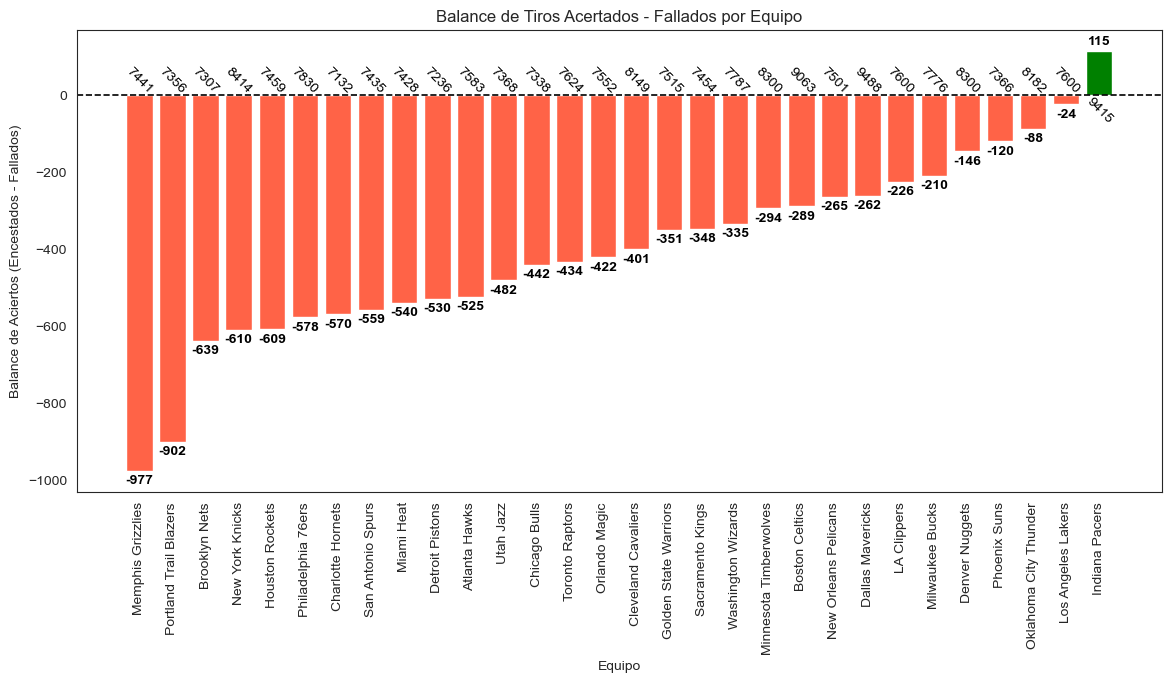

In [23]:
import matplotlib.pyplot as plt
import pandas as pd

# Calcular estadísticas por equipo
equipo_stats = df.groupby("TEAM_NAME").agg(
    tiros_totales=("SHOT_ATTEMPTED_FLAG", "sum"),  # Tiros intentados
    tiros_acertados=("SHOT_MADE_FLAG", "sum")  # Tiros anotados
)

# Calcular tiros fallados y balance de aciertos
equipo_stats["tiros_fallados"] = equipo_stats["tiros_totales"] - equipo_stats["tiros_acertados"]
equipo_stats["balance_aciertos"] = equipo_stats["tiros_acertados"] - equipo_stats["tiros_fallados"]

# Ordenar equipos por balance de aciertos
equipo_stats = equipo_stats.sort_values("balance_aciertos")

# Definir colores según balance de aciertos (verde si es positivo, rojo si es negativo)
colores = ["green" if x > 0 else "tomato" for x in equipo_stats["balance_aciertos"]]

# Crear gráfico de barras
fig, ax = plt.subplots(figsize=(14, 6))
bars = ax.bar(equipo_stats.index, equipo_stats["balance_aciertos"], color=colores)

# Línea en 0 para referencia
ax.axhline(0, color="black", linewidth=1.2, linestyle="--")

# Etiquetas y título
ax.set_xlabel("Equipo")
ax.set_ylabel("Balance de Aciertos (Encestados - Fallados)")
ax.set_title("Balance de Tiros Acertados - Fallados por Equipo")

# Corregir etiquetas del eje X
ax.set_xticks(range(len(equipo_stats.index)))  # Ubicaciones de las etiquetas
ax.set_xticklabels(equipo_stats.index, rotation=90)  # Rotar etiquetas del eje X

# Mostrar valores en las barras
for bar, total, balance in zip(bars, equipo_stats["tiros_totales"], equipo_stats["balance_aciertos"]):
    height = bar.get_height()
    
    # Texto sobre la barra (balance de aciertos)
    ax.text(bar.get_x() + bar.get_width()/2, height + (10 if height > 0 else -10), f"{int(balance)}",
            ha="center", va="bottom" if height > 0 else "top", fontsize=10, color="black", fontweight="bold")

    # Texto en el eje Y=0 (total de tiros intentados), rotado a 45 grados
    ax.text(bar.get_x() + bar.get_width()/2, 0, f"{int(total)}",
            ha="center", va="bottom" if height < 0 else "top", 
            fontsize=10, color="black", rotation=-45)

# Mostrar gráfico
plt.show()


## DISTRIBUCIÓN DE TIROS MEJOR Y PEOR EQUIPO EN BASE AL BALANCE DE TIROS ENCESTADOS- FALLADOS POR EQUIPO

In [24]:
from matplotlib.patches import Circle, Rectangle, Arc
import matplotlib.pyplot as plt
import pandas as pd

def plot_shot_distribution(team_name, season_type, df):
    # Filtrar datos
    filtered_df = df[
        (df["TEAM_NAME"] == team_name) & 
        (df["SEASON TYPE"] == season_type)
    ]
    filtered_df = filtered_df[filtered_df['LOC_Y'] <= 422.5]  # Limpiar datos
    
    if filtered_df.empty:
        raise ValueError(f"No hay datos para {team_name} en {season_type}")
    
    # Calcular estadísticas
    zone_stats = filtered_df.groupby("SHOT_ZONE_BASIC").agg(
        count=("SHOT_ATTEMPTED_FLAG", "size"),
        median_x=("LOC_X", "median"),
        median_y=("LOC_Y", "median")
    ).reset_index()
    zone_stats["percentage"] = zone_stats["count"] / zone_stats["count"].sum() * 100

    # Configuración de colores
    COLOR_3P = "#1f77b4"  # Azul
    COLOR_2P = "#2ca02c"  # Verde
    COLOR_BC = "#666666"  # Gris para Backcourt
    
    # Definiciones de zonas
    ZONE_STYLE = {
        'Above the Break 3': {'pos': (0, 280), 'color': COLOR_3P},
        'Left Corner 3': {'pos': (-220, 50), 'color': COLOR_3P},
        'Right Corner 3': {'pos': (220, 50), 'color': COLOR_3P},
        'Mid-Range': {'pos': (0, 170), 'color': COLOR_2P},
        'In The Paint (Non-RA)': {'pos': (0, 80), 'color': COLOR_2P},
        'Restricted Area': {'pos': (0, -15), 'color': COLOR_2P},
        'Backcourt': {'pos': (0, 400), 'color': COLOR_BC}
    }

    # Crear figura
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_xlim(-250, 250)
    ax.set_ylim(-47.5, 422.5)
    ax.set_aspect("equal")
    ax.axis('off')
    
    # 1. Puntos de tiro
    ax.scatter(
        filtered_df['LOC_X'], 
        filtered_df['LOC_Y'],
        s=25,
        alpha=0.15,
        color=COLOR_3P,  # Color base para puntos
        edgecolors='none'
    )
    
    # 2. Cancha
    draw_court(ax, color='#333333', lw=2, outer_lines=True)
    
    # 3. Anotaciones con colores diferenciados
    for zone, style in ZONE_STYLE.items():
        data = zone_stats[zone_stats['SHOT_ZONE_BASIC'] == zone]
        if not data.empty:
            pct = data['percentage'].iloc[0]
            ax.annotate(
                text=f"{zone}\n{pct:.1f}%",
                xy=style['pos'],
                ha='center',
                va='center',
                fontsize=9.5,
                color='white',
                weight='bold',
                linespacing=1.3,
                bbox=dict(
                    boxstyle="round,pad=0.4",
                    facecolor=style['color'],
                    alpha=0.9,
                    edgecolor='white',
                    linewidth=0.8
                )
            )

    plt.title(f"Distribución de tiros - {team_name}", pad=25, fontsize=14)
    return fig, ax

In [25]:
fig, ax = plot_shot_distribution(
    team_name="Memphis Grizzlies",
    season_type="Regular Season",
    df= df
)

# 2. Mostrarlo
plt.show(block=True)

In [26]:
fig, ax = plot_shot_distribution(
    team_name="Indiana Pacers",
    season_type="Regular Season",
    df= df
)

# 2. Mostrarlo
plt.show(block=True)